In [1]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import os
import glob

In [2]:
# Функция для поиска файла изображения
def find_image_file():
    # Возможные расширения изображений
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
    
    for ext in extensions:
        files = glob.glob(ext) + glob.glob(ext.upper())
        if files:
            return files[0]
    
    # Если не нашли, попробуем найти любой файл с цифрой 2 в названии
    for file in os.listdir('.'):
        if '2' in file and any(file.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.bmp']):
            return file
    
    return None

In [3]:
# Поиск файла изображения
image_file = find_image_file()

if image_file is None:
    print("Файл изображения не найден!")
    print("Пожалуйста, убедитесь, что файл '2.jpg' находится в той же папке, что и скрипт.")
    print("Текущая директория:", os.getcwd())
    print("Доступные файлы:")
    for file in os.listdir('.'):
        print(f"  - {file}")
    exit()

print(f"Найден файл: {image_file}")

Найден файл: 2.jpg


In [4]:
# Функция для сжатия одного канала с помощью SVD
def compress_channel(channel, k):
    U, S, V = np.linalg.svd(channel, full_matrices=False)
    compressed = U[:, :k] @ np.diag(S[:k]) @ V[:k, :]
    return compressed

In [5]:
# Функция для вычисления размера файла
def get_file_size(filepath):
    return os.path.getsize(filepath)

In [6]:
# Загрузка и подготовка изображения
try:
    img = Image.open(image_file)
    img_array = np.array(img, dtype=np.float32)
    
    print(f"Размер изображения: {img.size}")
    print(f"Формат массива: {img_array.shape}")
    
except Exception as e:
    print(f"Ошибка при загрузке изображения: {e}")
    exit()

Размер изображения: (2304, 1536)
Формат массива: (1536, 2304, 3)


In [7]:
# Размеры исходного изображения
original_size = get_file_size(image_file)

In [8]:
# Вариант 1: Сжатие в градациях серого (усреднение каналов)
if len(img_array.shape) == 3:
    gray_array = np.mean(img_array, axis=2).astype(np.float32)
    print("Изображение цветное, преобразуем в градации серого")
else:
    gray_array = img_array.astype(np.float32)
    print("Изображение черно-белое")


Изображение цветное, преобразуем в градации серого


In [9]:
# Значения k для сжатия
k_values = [1, 2, 10, 30, 100]

In [10]:
# Ограничим k максимальным возможным значением
max_k = min(gray_array.shape[0], gray_array.shape[1])
k_values = [k for k in k_values if k <= max_k]

print(f"Максимально возможное k: {max_k}")
print(f"Будем использовать k: {k_values}")

Максимально возможное k: 1536
Будем использовать k: [1, 2, 10, 30, 100]


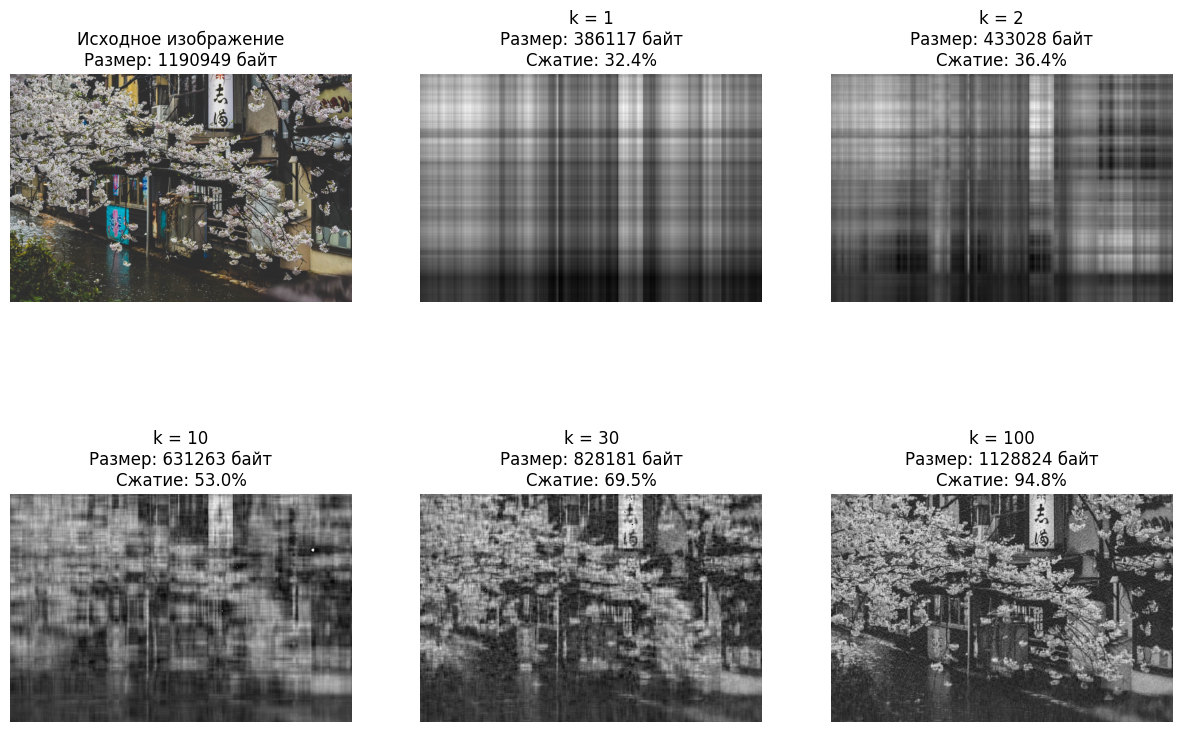

In [19]:
# Создаем график для отображения результатов
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Отображаем исходное изображение
if len(img_array.shape) == 3:
    axes[0].imshow(img_array.astype(np.uint8))
else:
    axes[0].imshow(img_array.astype(np.uint8), cmap='gray')
axes[0].set_title(f'Исходное изображение\nРазмер: {original_size} байт')
axes[0].axis('off')

# Сжимаем и отображаем для разных k
for i, k in enumerate(k_values, 1):
    # Сжимаем канал
    compressed_gray = compress_channel(gray_array, k)
    
    # Преобразуем обратно в изображение
    compressed_img = Image.fromarray(np.uint8(np.clip(compressed_gray, 0, 255)))
    
    # Сохраняем временно для определения размера
    temp_filename = f'compressed_k{k}.jpg'
    compressed_img.save(temp_filename, quality=95)
    compressed_size = get_file_size(temp_filename)
    
    # Отображаем
    axes[i].imshow(compressed_gray.astype(np.uint8), cmap='gray')
    axes[i].set_title(f'k = {k}\nРазмер: {compressed_size} байт\nСжатие: {compressed_size/original_size*100:.1f}%')
    axes[i].axis('off')
    
    # Удаляем временный файл
    os.remove(temp_filename)

In [14]:
# Скрываем пустые subplots если k_values меньше 5
for i in range(len(k_values) + 1, 6):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>


Цветное сжатие:


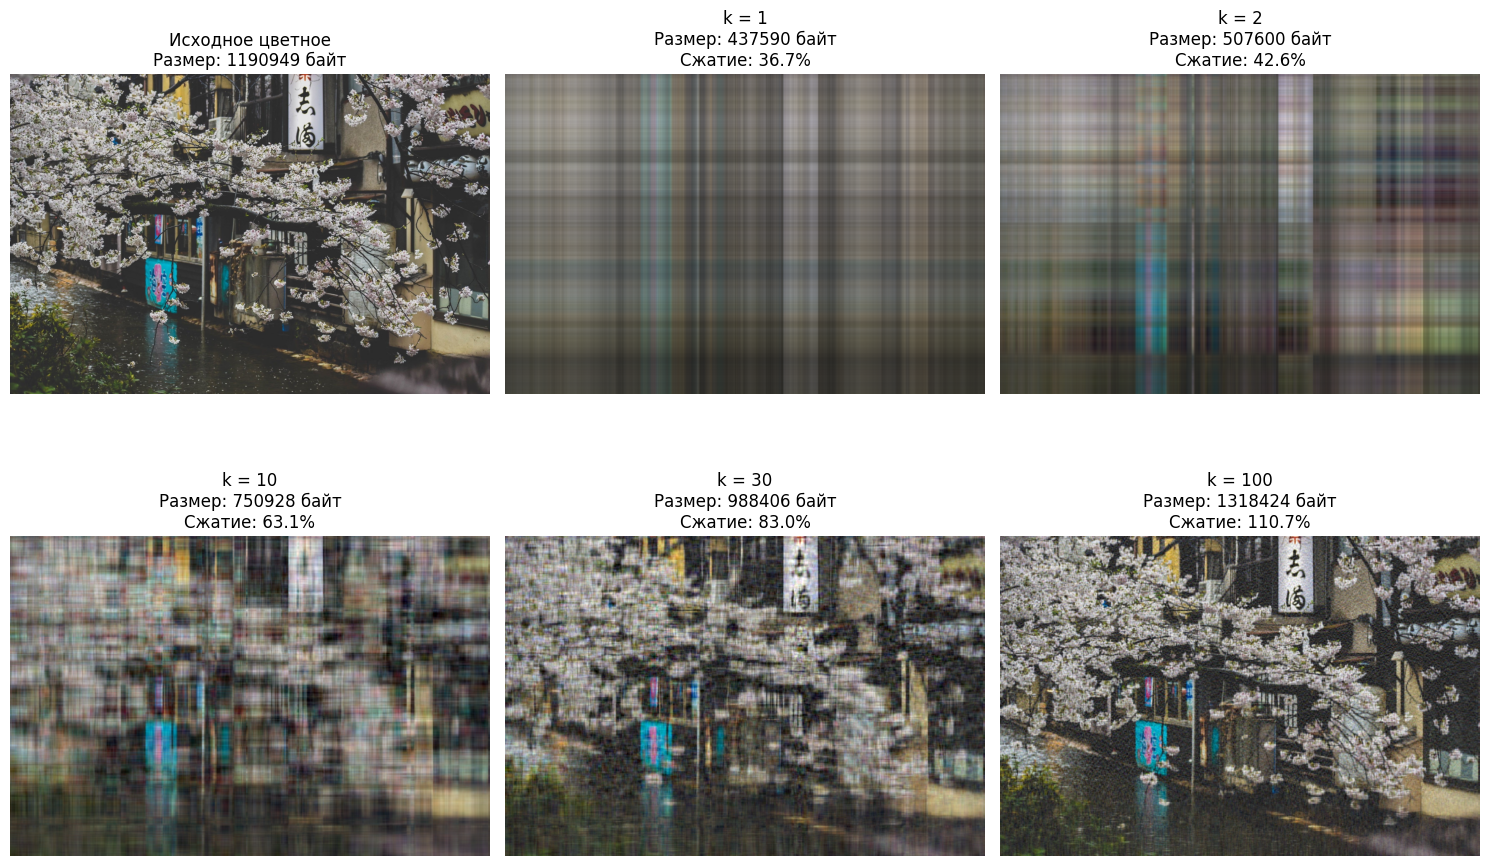


Сравнение эффективности сжатия:
k	Размер		% от исходного
----------------------------------------
1	386117 байт	32.4%
2	433028 байт	36.4%
10	631263 байт	53.0%
30	828181 байт	69.5%
100	1128824 байт	94.8%

Исходный размер: 1190949 байт
Имя файла: 2.jpg


In [17]:
# Вариант 2: Сжатие цветного изображения (по каналам)
if len(img_array.shape) == 3:
    print("\nЦветное сжатие:")
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    # Отображаем исходное цветное изображение
    axes[0].imshow(img_array.astype(np.uint8))
    axes[0].set_title(f'Исходное цветное\nРазмер: {original_size} байт')
    axes[0].axis('off')
    
    # Сжимаем каждый канал отдельно
    for i, k in enumerate(k_values, 1):
        compressed_channels = []
        for channel in range(3):  # R, G, B каналы
            compressed_channel = compress_channel(img_array[:, :, channel], k)
            compressed_channels.append(compressed_channel)
        
        # Объединяем каналы
        compressed_color = np.stack(compressed_channels, axis=2)
        compressed_color = np.clip(compressed_color, 0, 255)
        
        # Создаем изображение
        compressed_img = Image.fromarray(compressed_color.astype(np.uint8))
        
        # Сохраняем временно для определения размера
        temp_filename = f'compressed_color_k{k}.jpg'
        compressed_img.save(temp_filename, quality=95)
        compressed_size = get_file_size(temp_filename)
        
        # Отображаем
        axes[i].imshow(compressed_color.astype(np.uint8))
        axes[i].set_title(f'k = {k}\nРазмер: {compressed_size} байт\nСжатие: {compressed_size/original_size*100:.1f}%')
        axes[i].axis('off')
        
        # Удаляем временный файл
        os.remove(temp_filename)
    
    # Скрываем пустые subplots
    for i in range(len(k_values) + 1, 6):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Сравнение эффективности сжатия для разных k
print("\nСравнение эффективности сжатия:")
print("k\tРазмер\t\t% от исходного")
print("-" * 40)

for k in k_values:
    # Сжатие в градациях серого
    compressed_gray = compress_channel(gray_array, k)
    compressed_img = Image.fromarray(np.uint8(np.clip(compressed_gray, 0, 255)))
    temp_filename = f'temp_k{k}.jpg'
    compressed_img.save(temp_filename, quality=95)
    compressed_size = get_file_size(temp_filename)
    
    compression_ratio = compressed_size / original_size * 100
    print(f"{k}\t{compressed_size} байт\t{compression_ratio:.1f}%")
    
    os.remove(temp_filename)

print(f"\nИсходный размер: {original_size} байт")
print(f"Имя файла: {image_file}")